In [1]:
import random
import argparse
import numpy as np
import pandas as po
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from models.nbeats import NBeatsNet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [2]:
# set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
df = po.read_csv('final_data/multivariate.csv')
df

,consumption,Year,Month,DayOfYear,DayOfWeek,DayType,Hour,Minute,Season
0,126661.288667,2017,1,1,6,0,0,0,0
1,125975.630600,2017,1,1,6,0,0,15,0
2,131628.821400,2017,1,1,6,0,0,30,0
3,133741.109667,2017,1,1,6,0,0,45,0
4,149806.386667,2017,1,1,6,0,1,0,0
...,...,...,...,...,...,...,...,...,...
99643,103932.504002,2019,11,308,0,1,22,45,0
99644,102064.379714,2019,11,308,0,1,23,0,0
99645,100378.796042,2019,11,308,0,1,23,15,0
99646,98593.460339,2019,11,308,0,1,23,30,0


In [4]:
scaler = MinMaxScaler()
df = po.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [5]:
train_df = df[:int(0.6*len(df))]
val_df = df[int(0.6*len(df)): int(0.8*len(df))]
test_df = df[int(0.8*len(df)):]

In [6]:
len(train_df), len(val_df), len(test_df)

(59788, 19930, 19930)

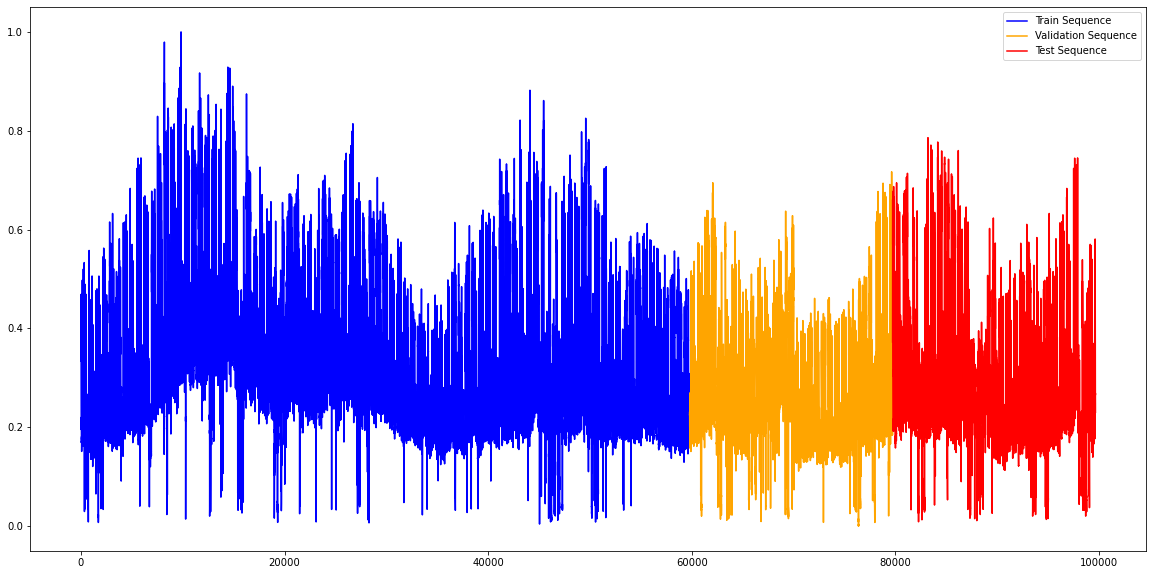

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(train_df['consumption'], color='blue')
plt.plot(val_df['consumption'], color='orange')
plt.plot(test_df['consumption'], color='red')
plt.legend(['Train Sequence', 'Validation Sequence', 'Test Sequence'])

In [8]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [9]:
lookback=4*24*14
horizon=4*24*1

In [10]:
def make_windows(data, target_col='consumption', lookback=4*24*14, horizon=4*24*1):
    
    X = np.zeros((len(data)-lookback - horizon + 1, lookback, len(data.columns)))
    y = np.zeros((len(data)-lookback - horizon + 1, horizon, 1))

    for i in tqdm(range(lookback, len(data) - horizon + 1)):  
        X[i-lookback, :, :] = data.iloc[i - lookback: i].values
        y[i-lookback, :, :] = data.iloc[i: i + horizon][target_col].values.reshape(-1, 1)

    return X, y

In [11]:
X_train, y_train = make_windows(train_df)

100%|██████████| 58349/58349 [00:22<00:00, 2621.73it/s]


In [12]:
X_val, y_val = make_windows(val_df)

100%|██████████| 18491/18491 [00:07<00:00, 2414.07it/s]


In [13]:
X_test, y_test = make_windows(test_df)

100%|██████████| 18491/18491 [00:07<00:00, 2476.89it/s]


In [14]:
#sgd = tf.keras.optimizers.SGD(lr=0.1, decay=1e-8, momentum=0.9, nesterov=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10)
loss_funk = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')

In [15]:
hidden_dim = 100
theta_1 = 100
theta_2 = 100
nb_blocks_per_stack = 20
seasonality = 4*24*7
batch_size = 256
num_epochs = 100

In [16]:
model = NBeatsNet(input_dim=len(train_df.columns), backcast_length = lookback, forecast_length = horizon,
                  stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK), nb_blocks_per_stack=nb_blocks_per_stack,
                  thetas_dim=(theta_1, theta_2), share_weights_in_stack=True, hidden_layer_units=hidden_dim)
          
model.compile_model(loss='mse', learning_rate=1e-4)

eneric/forecast[122][0]     
__________________________________________________________________________________________________
add_294 (Add)                   (None, 96)           0           add_285[0][0]                    
                                                                 1/0/generic/forecast[123][0]     
__________________________________________________________________________________________________
add_295 (Add)                   (None, 96)           0           add_286[0][0]                    
                                                                 1/0/generic/forecast[124][0]     
__________________________________________________________________________________________________
add_296 (Add)                   (None, 96)           0           add_287[0][0]                    
                                                                 1/0/generic/forecast[125][0]     
________________________________________________________________________________

In [17]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs = num_epochs, validation_data = (X_val, y_val), callbacks=[earlystop], verbose=1)

Epoch 1/100
228/228 [==============================] - 132s 580ms/step - loss: 17.8585 - val_loss: 0.2207
Epoch 2/100
228/228 [==============================] - 103s 450ms/step - loss: 0.1047 - val_loss: 0.1055
Epoch 3/100
228/228 [==============================] - 97s 425ms/step - loss: 0.0613 - val_loss: 0.0695
Epoch 4/100
228/228 [==============================] - 92s 405ms/step - loss: 0.0453 - val_loss: 0.0529
Epoch 5/100
228/228 [==============================] - 48s 211ms/step - loss: 0.0372 - val_loss: 0.0432
Epoch 6/100
228/228 [==============================] - 46s 204ms/step - loss: 0.0326 - val_loss: 0.0369
Epoch 7/100
228/228 [==============================] - 48s 209ms/step - loss: 0.0295 - val_loss: 0.0325
Epoch 8/100
228/228 [==============================] - 46s 203ms/step - loss: 0.0275 - val_loss: 0.0293
Epoch 9/100
228/228 [==============================] - 46s 201ms/step - loss: 0.0260 - val_loss: 0.0274
Epoch 10/100
228/228 [==============================] - 46s 2

In [29]:
model.save('saved_models/nbeats_multivariate.hdf5')

In [19]:
#model = tf.keras.models.load_model('saved_models/nbeats_univ.hdf5')

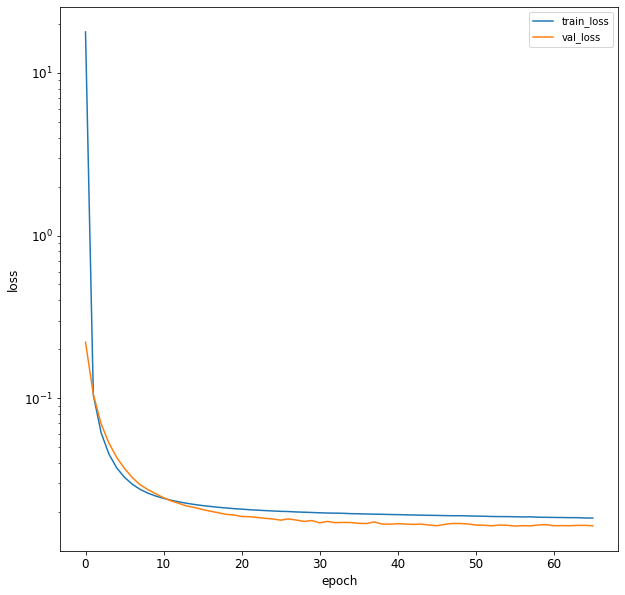

In [20]:
plot_df = po.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
#plt.savefig('forecasts/' + args.save_folder + '/train_val_loss.png')
plt.show()

In [34]:
model.predict(X_test).shape

(18491, 96, 9)

In [21]:
y_pred = model.predict(X_test)

In [22]:
y_pred = y_pred.squeeze()
y_test = y_test.squeeze()

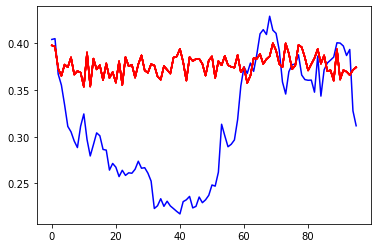

In [32]:
plt.plot(y_test[5511], color = 'blue')
plt.plot(y_pred[5511], color = 'red')
#plt.savefig('forecasts/' + args.save_folder + '/test_1_pred.png')

In [24]:
forecasts = []
actuals = []
forecasts_n = []
actuals_n = []
for i in tqdm(range(y_pred.shape[0]//288)): ## we have forecasts for these many complete day
  forecasts += (scaler.inverse_transform(y_pred[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()
  actuals += (scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()
  forecasts_n += y_pred[12*24*i].tolist()
  actuals_n += y_test[12*24*i].tolist()

0%|          | 0/64 [00:00<?, ?it/s]


ValueError: non-broadcastable output operand with shape (864,1) doesn't match the broadcast shape (864,9)

In [ ]:
df_pred = po.DataFrame()
df_pred['Predictions'] = forecasts
df_pred['Actual Values'] = actuals

In [ ]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts) + 1, 288)), labels = list(range(0, int(len(forecasts)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.plot(actuals, color = 'blue')
plt.plot(forecasts, color = 'red')
plt.legend(['Actual Value', 'Prediction'])

In [ ]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts) + 1, 288)), labels = list(range(0, int(len(forecasts)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.plot(actuals_n, color = 'blue')
plt.plot(forecasts_n, color = 'red')
plt.legend(['Actual Value', 'Prediction'])

In [ ]:
results = po.DataFrame(columns = ['MAE', 'MSE', 'R2'])  
errors = {'MAE': mean_absolute_error(y_true=y_test, y_pred=y_pred),
          'MAPE': mean_absolute_error(y_true=y_test, y_pred=y_pred)*100,
          'MSE': mean_squared_error(y_true=y_test, y_pred=y_pred),
          'RMSE': mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False),
          'R2': r2_score(y_true=y_test, y_pred=y_pred)          
          }
errors = po.Series(errors)
results = results.append(errors, ignore_index=True)
results